In [29]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, classification_report, mean_absolute_error, mean_squared_error
from xgboost import XGBRegressor

import shap
import matplotlib.pyplot as plt
shap.initjs()


In [2]:
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
wine_quality = fetch_ucirepo(id=186) 
  
# data (as pandas dataframes) 
X = wine_quality.data.features 
y = wine_quality.data.targets 
  
# metadata 
wine_quality.metadata
  
# variable information 
wine_quality.variables


,name,role,type,demographic,description,units,missing_values
0,fixed_acidity,Feature,Continuous,None,None,None,no
1,volatile_acidity,Feature,Continuous,None,None,None,no
2,citric_acid,Feature,Continuous,None,None,None,no
3,residual_sugar,Feature,Continuous,None,None,None,no
4,chlorides,Feature,Continuous,None,None,None,no
5,free_sulfur_dioxide,Feature,Continuous,None,None,None,no
6,total_sulfur_dioxide,Feature,Continuous,None,None,None,no
7,density,Feature,Continuous,None,None,None,no
8,pH,Feature,Continuous,None,None,None,no
9,sulphates,Feature,Continuous,None,None,None,no


In [5]:
X

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4
...,...,...,...,...,...,...,...,...,...,...,...
6492,6.2,0.21,0.29,1.6,0.039,24.0,92.0,0.99114,3.27,0.50,11.2
6493,6.6,0.32,0.36,8.0,0.047,57.0,168.0,0.99490,3.15,0.46,9.6
6494,6.5,0.24,0.19,1.2,0.041,30.0,111.0,0.99254,2.99,0.46,9.4
6495,5.5,0.29,0.30,1.1,0.022,20.0,110.0,0.98869,3.34,0.38,12.8


In [21]:
y.value_counts()

quality
6          2836
5          2138
7          1079
4           216
8           193
3            30
9             5
Name: count, dtype: int64

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, shuffle=True, random_state=305)

In [9]:
xgb = XGBRegressor(
    n_estimators=200,
    learning_rate=0.03,
    max_depth=4,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0.0,
    reg_lambda=1.0,
    objective="reg:squarederror",
    random_state=42,
    n_jobs=-1
)

In [10]:
xgb.fit(X_train, y_train)

,"objective objective: typing.Union[str, xgboost.sklearn._SklObjWProto, typing.Callable[[typing.Any, typing.Any], typing.Tuple[numpy.ndarray, numpy.ndarray]], NoneType]Specify the learning task and the corresponding learning objective or a customobjective function to be used.For custom objective, see :doc:`/tutorials/custom_metric_obj` and:ref:`custom-obj-metric` for more information, along with the end note forfunction signatures.",'reg:squarederror'
,"base_score base_score: typing.Union[float, typing.List[float], NoneType]The initial prediction score of all instances, global bias.",None
,booster,None
,"callbacks callbacks: typing.Optional[typing.List[xgboost.callback.TrainingCallback]]List of callback functions that are applied at end of each iteration.It is possible to use predefined callbacks by using:ref:`Callback API `... note:: States in callback are not preserved during training, which means callback objects can not be reused for multiple training sessions without reinitialization or deepcopy... code-block:: python for params in parameters_grid: # be sure to (re)initialize the callbacks before each run callbacks = [xgb.callback.LearningRateScheduler(custom_rates)] reg = xgboost.XGBRegressor(**params, callbacks=callbacks) reg.fit(X, y)",None
,colsample_bylevel colsample_bylevel: typing.Optional[float]Subsample ratio of columns for each level.,None
,colsample_bynode colsample_bynode: typing.Optional[float]Subsample ratio of columns for each split.,None
,colsample_bytree colsample_bytree: typing.Optional[float]Subsample ratio of columns when constructing each tree.,0.8
,"device device: typing.Optional[str].. versionadded:: 2.0.0Device ordinal, available options are `cpu`, `cuda`, and `gpu`.",None
,"early_stopping_rounds early_stopping_rounds: typing.Optional[int].. versionadded:: 1.6.0- Activates early stopping. Validation metric needs to improve at least once in every **early_stopping_rounds** round(s) to continue training. Requires at least one item in **eval_set** in :py:meth:`fit`.- If early stopping occurs, the model will have two additional attributes: :py:attr:`best_score` and :py:attr:`best_iteration`. These are used by the :py:meth:`predict` and :py:meth:`apply` methods to determine the optimal number of trees during inference. If users want to access the full model (including trees built after early stopping), they can specify the `iteration_range` in these inference methods. In addition, other utilities like model plotting can also use the entire model.- If you prefer to discard the trees after `best_iteration`, consider using the callback function :py:class:`xgboost.callback.EarlyStopping`.- If there's more than one item in **eval_set**, the last entry will be used for early stopping. If there's more than one metric in **eval_metric**, the last metric will be used for early stopping.",None
,enable_categorical enable_categorical: boolSee the same parameter of :py:class:`DMatrix` for details.,False
,"eval_metric eval_metric: typing.Union[str, typing.List[typing.Union[str, typing.Callable]], typing.Callable, NoneType].. versionadded:: 1.6.0Metric used for monitoring the training result and early stopping. It can be astring or list of strings as names of predefined metric in XGBoost (See:doc:`/parameter`), one of the metrics in :py:mod:`sklearn.metrics`, or anyother user defined metric that looks like `sklearn.metrics`.If custom objective is also provided, then custom metric should implement thecorresponding reverse link function.Unlike the `scoring` parameter commonly used in scikit-learn, when a callableobject is provided, it's assumed to be a cost function and by default XGBoostwill minimize the result during early stopping.For advanced usage on Early stopping like directly choosing to maximize insteadof minimize, see :py:obj:`xgboost.callback.EarlyStopping`.See :doc:`/tutorials/custom_metric_obj` and :ref:`custom-obj-metric` for moreinformation... code-block:: python from sklearn.datasets import load_diabetes 

In [14]:
pred = xgb.predict(X_test)

In [15]:
rmse = mean_squared_error(y_test, pred) ** 0.5
mae = mean_absolute_error(y_test, pred)

print("RMSE:", rmse)
print("MAE:", mae)

RMSE: 0.6589539091782021
MAE: 0.510777473449707


In [25]:
# explain the GAM model with SHAP
explainer_xgb = shap.Explainer(xgb)
shap_values_xgb = explainer_xgb(X_test)

In [27]:
np.shape(shap_values_xgb)

(1300, 11)

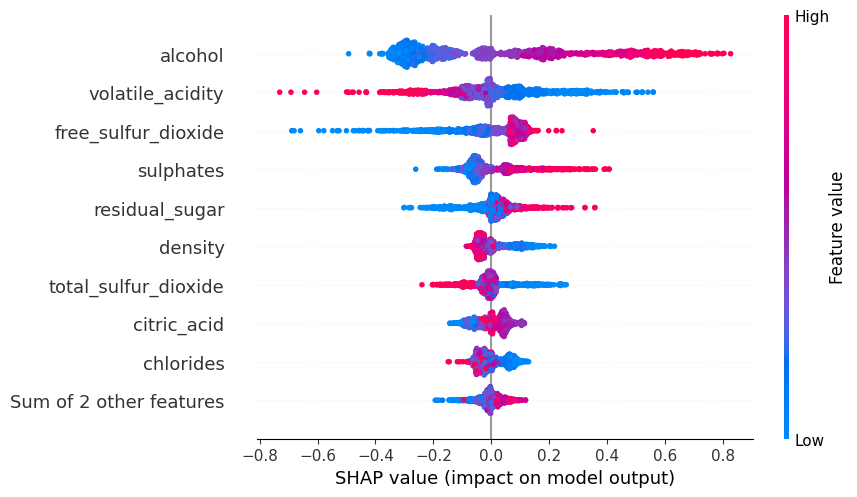

In [ ]:
# as alcohol increases the SHAP value increases
shap.plots.beeswarm(shap_values_xgb) 

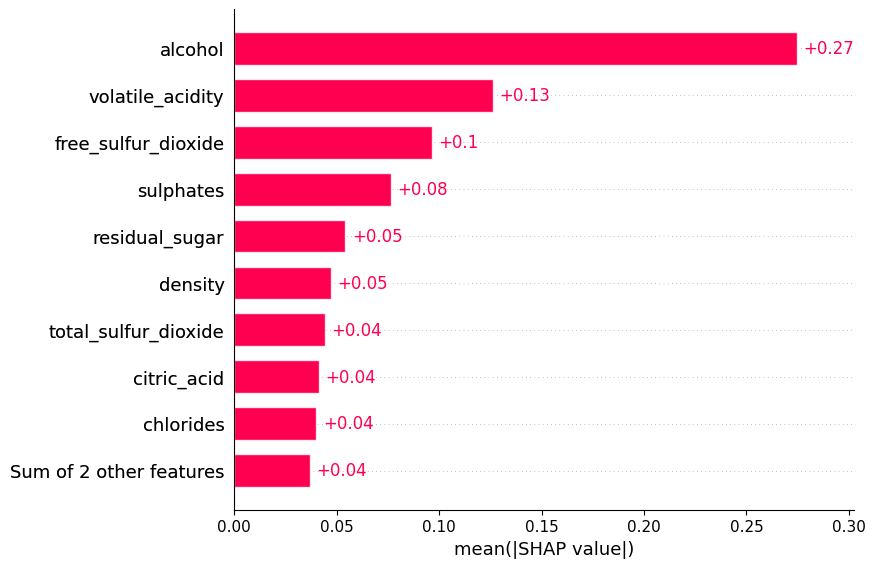

In [ ]:
# features that made significant contribution to predictions
shap.plots.bar(shap_values_xgb)

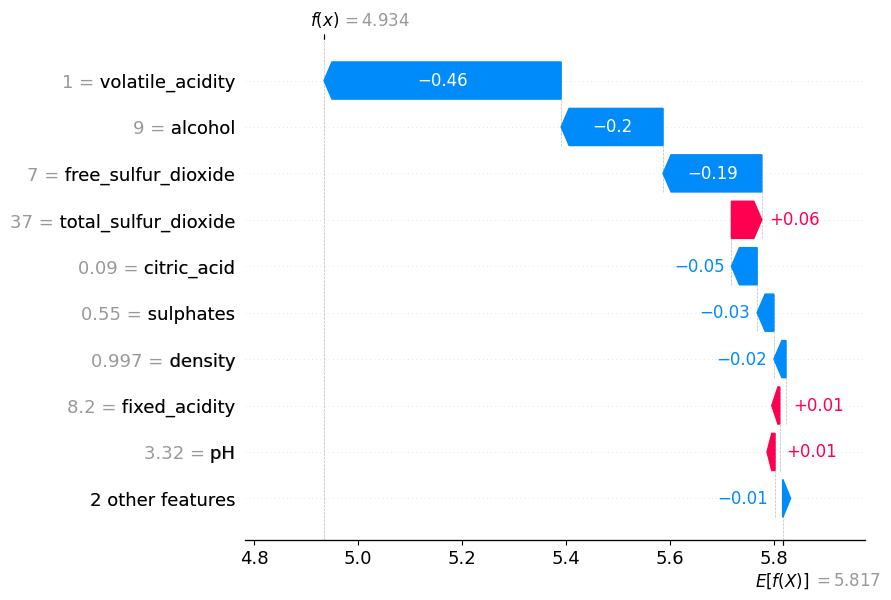

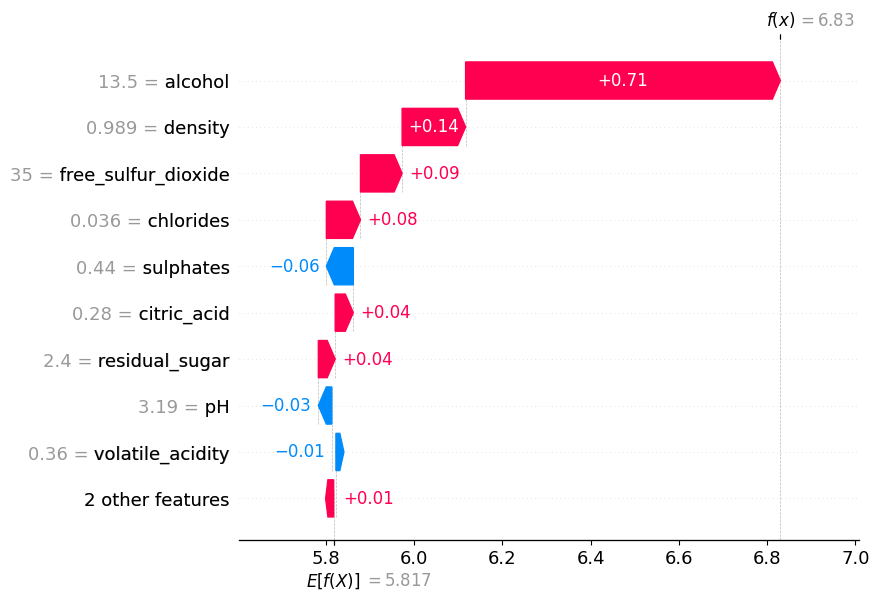

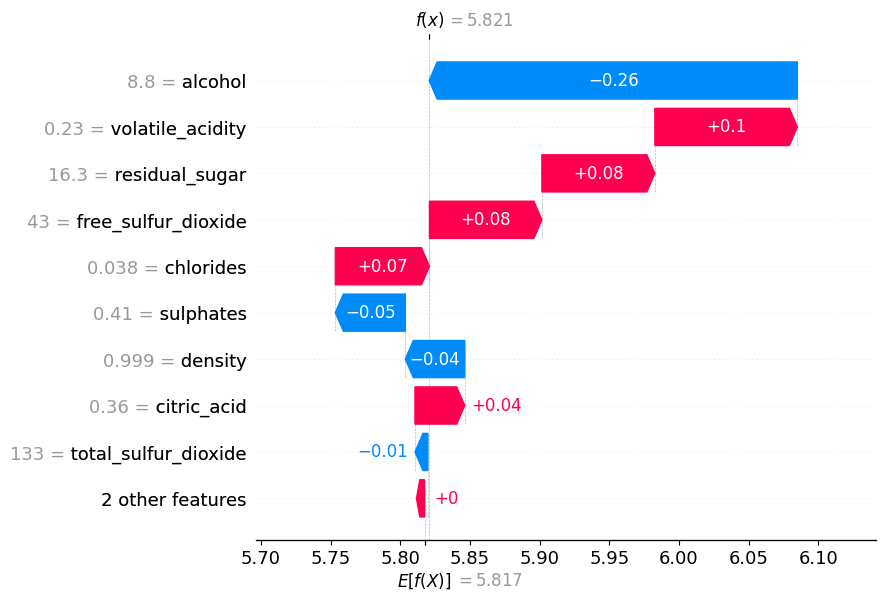

In [39]:
# E(f(X)) average predicted quality across test set
# f(x) is the predicted quality of this wine
# the SHAP values tell how to get between E(f(x)) and f(x)
shap.plots.waterfall(shap_values_xgb[5])
shap.plots.waterfall(shap_values_xgb[1])
shap.plots.waterfall(shap_values_xgb[2])

In [30]:
shap.plots.force(shap_values_xgb[1])

In [ ]:
# as alcohol increases the SHAP increases and te quality of wine is better
shap.plots.force(shap_values_xgb[0:100])

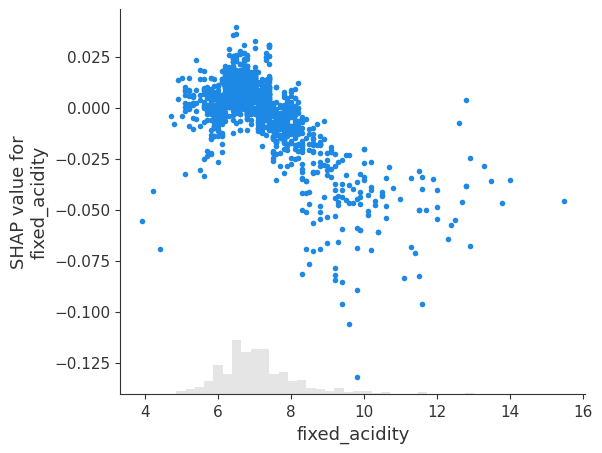

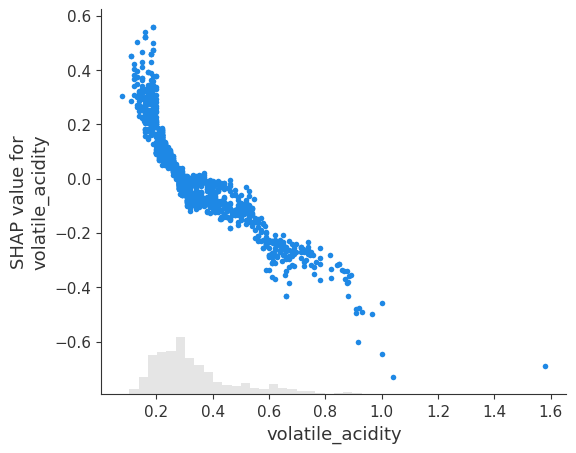

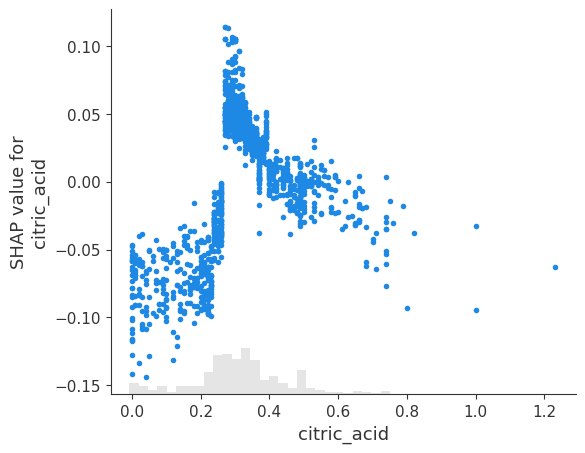

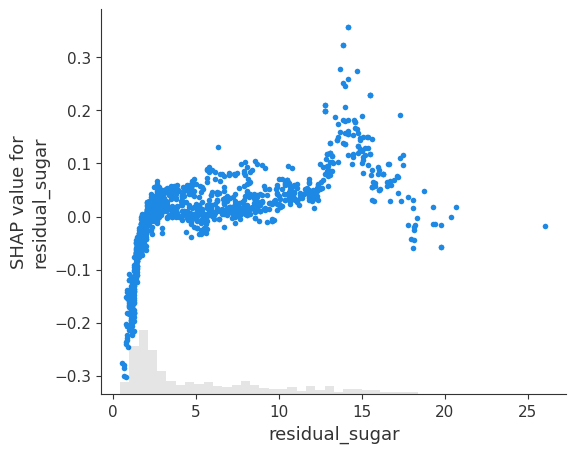

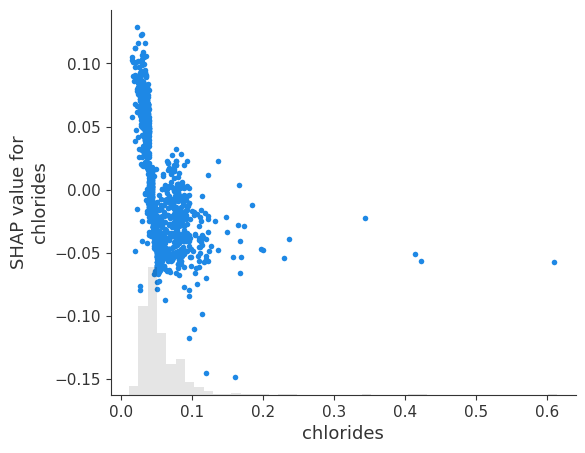

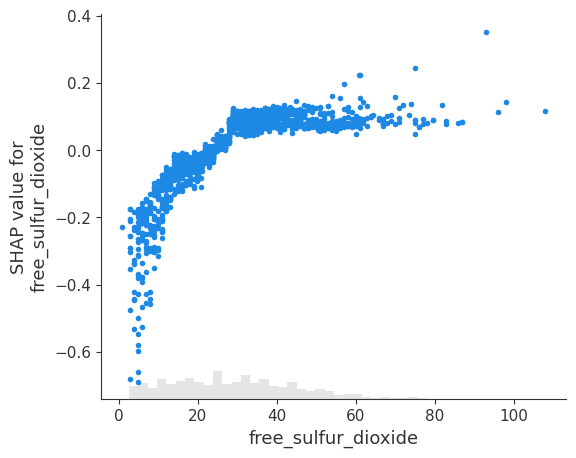

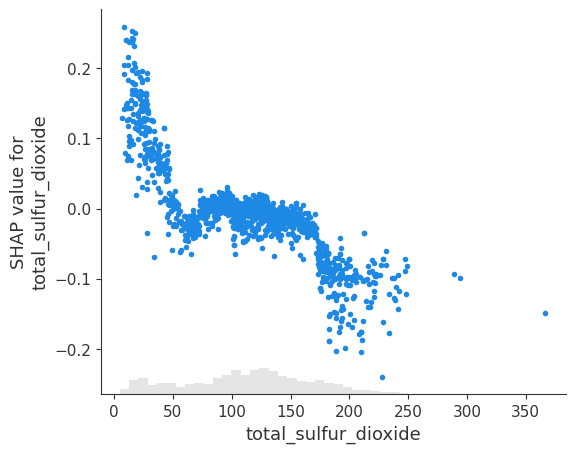

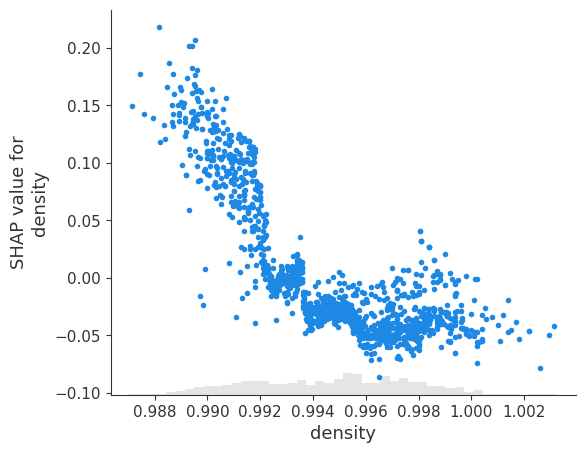

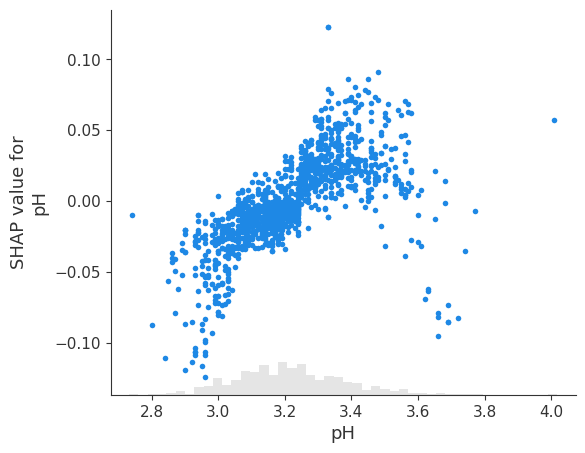

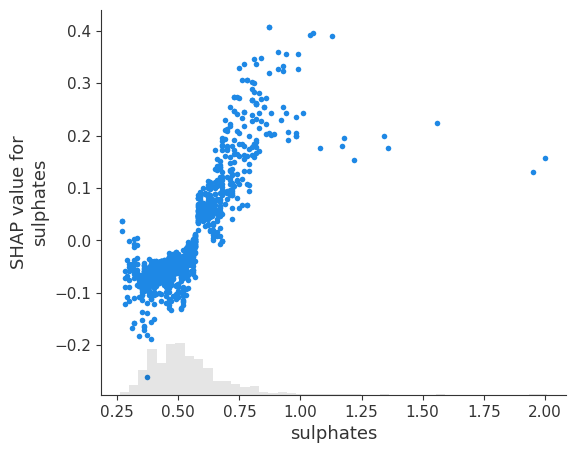

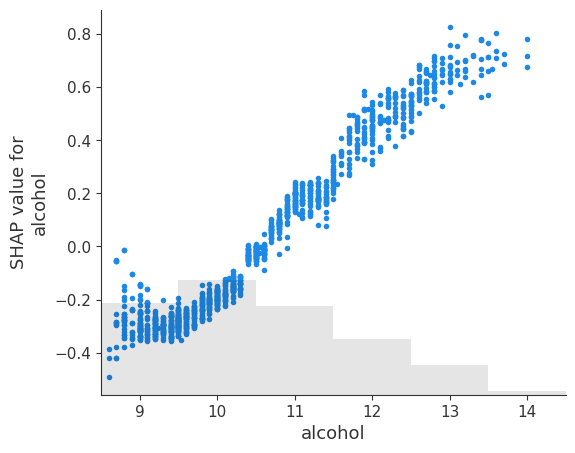

In [35]:
# dependence
for col in X_test.columns:
    shap.plots.scatter(shap_values_xgb[:, col])